<a href="https://colab.research.google.com/github/travislatchman/TheHearts/blob/main/Updated_Cardiac_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import librosa
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

### example placeholder for an audio file

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load audio file
file_path = "/content/drive/MyDrive/MLMA Group/CardiacData/DatasetA/normal/201106151236.wav"
audio_signal, sample_rate = librosa.load(file_path, sr=None)

### Functions from my audio project

In [ ]:
def noise_reduction(audio_signal, sample_rate, noise_window_duration=0.5):
    window_size = sample_rate // 10
    overlap = window_size // 2
    noise_window_size = int(noise_window_duration * sample_rate)

    # Calculate the spectrogram of the input signal
    _, _, stft = signal.stft(audio_signal, fs=sample_rate, nperseg=window_size, noverlap=overlap)

    # Calculate the average noise profile within the noise window
    noise_profile = np.mean(np.abs(stft[:, :noise_window_size])**2, axis=1)
    noise_profile = np.sqrt(noise_profile)

    # Perform spectral subtraction to reduce noise
    stft_noise_reduced = stft - noise_profile[:, np.newaxis]
    stft_noise_reduced = np.maximum(stft_noise_reduced, 0)

    # Compute the inverse STFT to obtain the denoised signal
    _, denoised_signal = signal.istft(stft_noise_reduced, fs=sample_rate, nperseg=window_size, noverlap=overlap)

    return denoised_signal

In [ ]:
denoised_signal = noise_reduction(audio_signal, sample_rate)

In [ ]:
# Preprocessing
def preprocess_audio(audio_signal, sample_rate):
    # Noise reduction (spectral subtraction)
    denoised_signal = noise_reduction(audio_signal, sample_rate)

    # Normalize the audio signal
    normalized_signal = librosa.util.normalize(denoised_signal)
    return normalized_signal

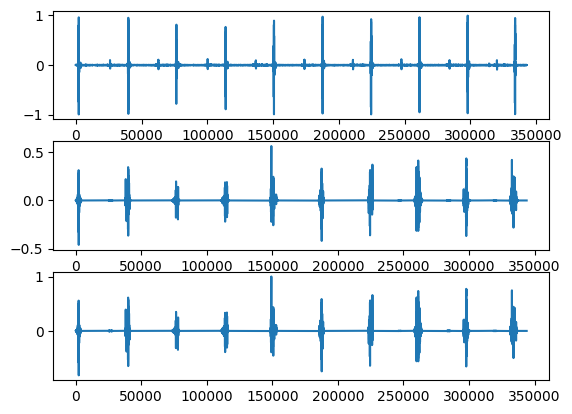

In [ ]:
preprocessed_audio = preprocess_audio(audio_signal, sample_rate)

fig,axs = plt.subplots(nrows=3, ncols=1)
axs[0].plot(audio_signal)
axs[1].plot(denoised_signal)
axs[2].plot(preprocessed_audio)
plt.show()

In [ ]:
from IPython.display import Audio, display

display(Audio(audio_signal,rate=sample_rate))

In [ ]:
# Feature Extraction
def extract_features(audio_signal, sample_rate):
    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=audio_signal, sr=sample_rate)

    # Extract spectral features
    spectral_centroid = librosa.feature.spectral_centroid(y=audio_signal, sr=sample_rate)
    spectral_flux = librosa.onset.onset_strength(y=audio_signal, sr=sample_rate)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=audio_signal, sr=sample_rate)

    # Compute STFT
    stft = librosa.stft(audio_signal)

    # (Optional) Compute CWT
    # cwt = signal.cwt(audio_signal, signal.ricker, np.arange(1, 31))

    return mfccs, spectral_centroid, spectral_flux, spectral_rolloff, stft



In [ ]:
# output - features that will be input to peak detection algorithm
mfccs, spectral_centroid, spectral_flux, spectral_rolloff, stft = extract_features(audio_signal, sample_rate)

### Cardiac Specific (not sure if these work, but looking for S1 and S2 peaks, and then segmenting accordingly?)

made peak detection to use the extracted features from above

In [ ]:
def peak_detection(audio_signal, sample_rate, features):
    # Calculate the onset envelope
    onset_env = librosa.onset.onset_strength(y=audio_signal, sr=sample_rate)

    # Detect the peaks in the onset envelope
    peaks, _ = signal.find_peaks(audio_signal, distance=sample_rate//4)

    # Separate the detected peaks into S1 and S2 sounds based on their amplitude
    peak_amplitudes = audio_signal[peaks]
    median_amplitude = np.median(peak_amplitudes)

    s1_locs = peaks[peak_amplitudes >= median_amplitude]
    s2_locs = peaks[peak_amplitudes < median_amplitude]

    return s1_locs, s2_locs

In [ ]:
s1_locs, s2_locs = peak_detection(preprocessed_audio, sample_rate, (mfccs, spectral_centroid, spectral_flux, spectral_rolloff))

S1 locations: [  2189  39941 149196 187544 226313 261251 297924 332718]
S2 locations: [ 25678  76511 115307 137458 173388 247742 285246 318903]


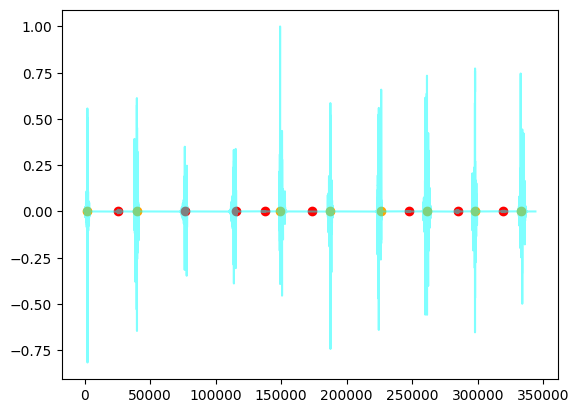

In [ ]:
print("S1 locations:", s1_locs)
print("S2 locations:", s2_locs)

plt.plot(preprocessed_audio, alpha=0.5, c='cyan')
plt.scatter(s1_locs, np.zeros(len(s1_locs)), c='orange')
plt.scatter(s2_locs, np.zeros(len(s2_locs)), c='red')

In [ ]:
def segmentation(audio_signal, s1_locs, s2_locs, sample_rate):
    segments = []
    s1_s2_pairs = zip(s1_locs, s2_locs)

    for s1, s2 in s1_s2_pairs:
        # Check if the next S1 location is in the list
        next_s1_index = np.where(s1_locs == s1)[0][0] + 1
        if next_s1_index < len(s1_locs):
            next_s1 = s1_locs[next_s1_index]
            cardiac_cycle = audio_signal[s1:next_s1]
            segments.append(cardiac_cycle)
    
    return segments

In [ ]:
segments = segmentation(audio_signal, s1_locs, s2_locs, sample_rate)

Number of segments: 13


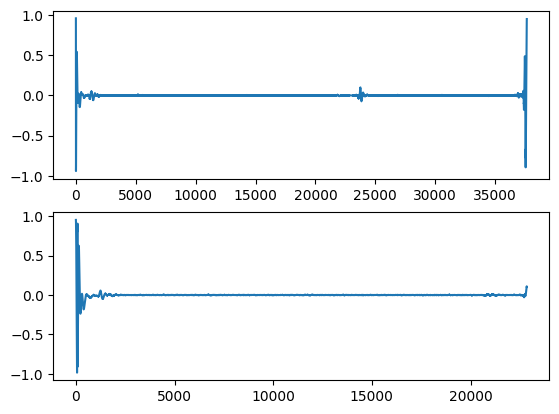

In [ ]:
print("Number of segments:", len(segments))

fig,axs = plt.subplots(nrows=2, ncols=1)
axs[0].plot(segments[0])
axs[1].plot(segments[1])

### To consider duration (modified cardiac functions from above) 

modified peak detection for duration

In [ ]:
def cardiac_cycle_detection(audio_signal, sample_rate):
    # Calculate the onset envelope
    onset_env = librosa.onset.onset_strength(y=audio_signal, sr=sample_rate)

    # Detect the peaks in the onset envelope
    peaks, _ = signal.find_peaks(onset_env, distance=sample_rate // 4)

    # Separate the detected peaks into S1 and S2 sounds based on their amplitude
    peak_amplitudes = onset_env[peaks]
    median_amplitude = np.median(peak_amplitudes)

    s1_locs = peaks[peak_amplitudes >= median_amplitude]
    s2_locs = peaks[peak_amplitudes < median_amplitude]

    # Calculate the duration of cardiac cycles (using S1 locations)
    cardiac_cycle_durations = np.diff(s1_locs)

    return s1_locs, s2_locs, cardiac_cycle_durations

modified segmentation to include clip length and hanning window

In [ ]:
def cardiac_cycle_segmentation(audio_signal, s1_locs, s2_locs, sample_rate, clip_duration=1):
    clip_length = sample_rate * clip_duration
    segments = []

    for s1, s2 in zip(s1_locs, s2_locs):
        # Check if the next S1 location is in the list
        next_s1_index = np.where(s1_locs == s1)[0][0] + 1
        if next_s1_index < len(s1_locs):
            next_s1 = s1_locs[next_s1_index]

            # Calculate the start and end positions of the 1-second audio clip
            clip_start = s1
            clip_end = min(s1 + clip_length, next_s1)

            # Extract the audio clip
            audio_clip = audio_signal[clip_start:clip_end]

            # Apply a windowing function (e.g., Hanning) to minimize discontinuities
            window = np.hanning(len(audio_clip))
            audio_clip = audio_clip * window

            segments.append(audio_clip)

    return segments

In [ ]:
s1_locs, s2_locs, cardiac_cycle_durations = cardiac_cycle_detection(audio_signal, sample_rate)
segments = cardiac_cycle_segmentation(audio_signal, s1_locs, s2_locs, sample_rate)

print("Number of segments:", len(segments))

TypeError: ignored